<h1><center>Predicting the effect of soil and moisture variations on the interpretive potential of frequency domain electromagnetics</center></h1>
<h3><center>Daan Hanssens and Philippe De Smedt</center></h3>

## Introduction
Due to the diverse nature of different soil parameters and combination of different frequency domain eletromagnetic (FDEM) instrumentation, we present an interactive tool to assess each individual case separately, and allow flexible integration of the suggested methodology. Such a tool can be expanded towards evaluating the influence of moisture variation on different types of geo-electrical instrumentation, simply by integrating the relevant forward modelling algorithms. For FDEM surveys particularly, this will allow clear evaluation of the influence of soil moisture on both the QP and IP signal for investigated terrains.

In [1]:
# Import
import numpy as np
import pandas as pd
import FDEM1D  # https://github.com/dhanssens/FDEM1D
import matplotlib.pyplot as plt
%matplotlib inline

# Font family and size
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.size'] = 20

## The Generalized Archie’s Law
The Generalized Archie’s Law (Shah and Singh, 2005) was used for evaluating moisture-dependent electrical conductivity in unsaturated porous media and is defined as follows:

\begin{equation*}
\sigma = c \sigma_w \theta^m
\end{equation*}

where,  
$\qquad$$\sigma$ is the electrical conductivity of the soil expressed in Siemens per meter (S/m),  
$\qquad$$\sigma_w$ is the electrical conductivity of the pore solution expressed in Siemens per meter (S/m),  
$\qquad$$\theta$ is the volumetric moisture content (dimensionless) and,  
$\qquad$$c$ and $m$ are the (dimensionless) fitting parameters which can be estimated based on the clay content ($CL$) expressed in percentage (%).

For $CL ≥ 5%$:

\begin{equation*}
c=0.6*CL^{0.55} \\
m=0.92*CL^{0.2}
\end{equation*}

For $CL < 5%$:
\begin{equation*}
c=1.45\\
m=1.25\\
\end{equation*}

In [2]:
# Generalized Archie's Law
def archie(vol_moist_cont, con_pore_sol, clay_cont=0, c=1.45, m=1.25):

    # Calculate coefficients defined by clay content
    if clay_cont >= 5:
        c = .6 * clay_cont ** .55
        m = .92 * clay_cont ** .2

    # Return electrical conductivity of the soil
    return c * con_pore_sol * vol_moist_cont ** m

## Predicting FDEM contrasts based on profile information
Synthetic models, agreeing to the characteristics of the profiles can be build using the Generalized Archie's Law equation and integrated into a 1D forward modelling procedure (Hanssens et al., 2019) to predict QP and IP responses and contrasts. The contrasts are classified as detectable when the absolute difference exceeds the coil configuration its associated noise level.

### Instrument characteristics

In [3]:
# Sensor characteristics
x = 1.0                 # x-coordinate receiver (m)
height = .165           # Height of transmitter (m)
freq = 9e3              # Frequency (Hz)
mom = 1                 # Transmitter moment (A m**2)
ori = 'YY'              # Coil orientation ('ZZ': HCP, 'ZX': PRP, 'YY': VCP)
noise = 50              # Instrument noise (ppm)

In [4]:
# Fixed sensor characteristics in 1D for horizontal instrument
y = .0                  # y-coordinate receiver (m)
z = - height            # z-coordinate receiver (m)

### Profile characteristics

In [5]:
# Create DataFrame structures for profiles 1 and 2
profile_1 = pd.DataFrame(columns=['thick', 'mag_sus', 'vol_moist_cont', 'con_pore_sol', 'clay_cont', 'archie_ec'])
profile_2 = profile_1.copy()

#### Profile 1

In [6]:
# Profile 1 characteristics [layer 0, layer 1, ..., layer N-1, layer N]
profile_1.thick = [.2, .5, np.nan]          # Layer(s) thickness (m), last layer is assumed to be endless
profile_1.mag_sus = [0, 11e-5, 12e-5]       # Magnetic susceptibility of layer(s) (-)
profile_1.vol_moist_cont = [.7, .8, .8]     # Volumetric moisture content of layer(s) (-)
profile_1.con_pore_sol = [.015, .025, .01]  # Electrical conductivity of pore solution of layer(s) (S/m)
profile_1.clay_cont = [33, 40, 30]          # Clay content of layer(s) (%)

# Summary of Profile 1
profile_1.head()

,thick,mag_sus,vol_moist_cont,con_pore_sol,clay_cont,archie_ec
0,0.2,0.00000,0.7,0.015,33,NaN
1,0.5,0.00011,0.8,0.025,40,NaN
2,NaN,0.00012,0.8,0.010,30,NaN


#### Profile 2

In [7]:
# Profile 2 characteristics [layer 0, layer 1, ..., layer N-1, layer N]
profile_2.thick = [.2, np.nan]           # Layer(s) thickness (m), last layer is assumed to be endless
profile_2.mag_sus = [0, 9e-5]            # Magnetic susceptibility of layer(s) (-)
profile_2.vol_moist_cont = [.7, .8]      # Volumetric moisture content of layer(s) (-)
profile_2.con_pore_sol = [.015, .025]    # Electrical conductivity of pore solution of layer(s) (S/m)
profile_2.clay_cont = [33, 40]           # Clay content of layer(s) (%)

# Summary of Profile 2
profile_2.head()

,thick,mag_sus,vol_moist_cont,con_pore_sol,clay_cont,archie_ec
0,0.2,0.00000,0.7,0.015,33,NaN
1,NaN,0.00009,0.8,0.025,40,NaN


#### Calculating electrical conductivity based on Archie's Law

In [8]:
# Calculate electrical conductivity (S/m) of each layer for profiles 1 and 2
profile_1.archie_ec = [archie(profile_1.vol_moist_cont.values[lay], 
                              profile_1.con_pore_sol.values[lay], 
                              profile_1.clay_cont.values[lay]) 
                       for lay in range(profile_1.shape[0])]
profile_2.archie_ec = [archie(profile_2.vol_moist_cont.values[lay], 
                              profile_2.con_pore_sol.values[lay], 
                              profile_2.clay_cont.values[lay]) 
                       for lay in range(profile_2.shape[0])]

### Forward modelling procedure

In [9]:
# Create model object for profile 1
model_p1 = FDEM1D.Model(profile_1.thick.values, 
                        profile_1.mag_sus.values, 
                        profile_1.archie_ec, 
                        profile_1.mag_sus.values * 0  # Dielectric permittiviy
                        )

# Create model object for profile 2
model_p2 = FDEM1D.Model(profile_2.thick.values, 
                        profile_2.mag_sus.values, 
                        profile_2.archie_ec, 
                        profile_2.mag_sus.values * 0  # Dielectric permittiviy
                        )

# Create sensor object
sensor = FDEM1D.Sensor(x, y, z, height, freq, mom, ori)                 

# Calculate forward QP and IP responses of both profiles
ip_p1, qp_p1 = FDEM1D.Calculate(sensor, model_p1).forward()
ip_p2, qp_p2 = FDEM1D.Calculate(sensor, model_p2).forward()

C:\Users\dhanssen\Documents\Python Scripts\FDEM1D.py:560: RuntimeWarning: overflow encountered in tanh
  tanh_uh = np.tanh(u[:, i] * self.Model.thick[i])


### Detectability of contrasts

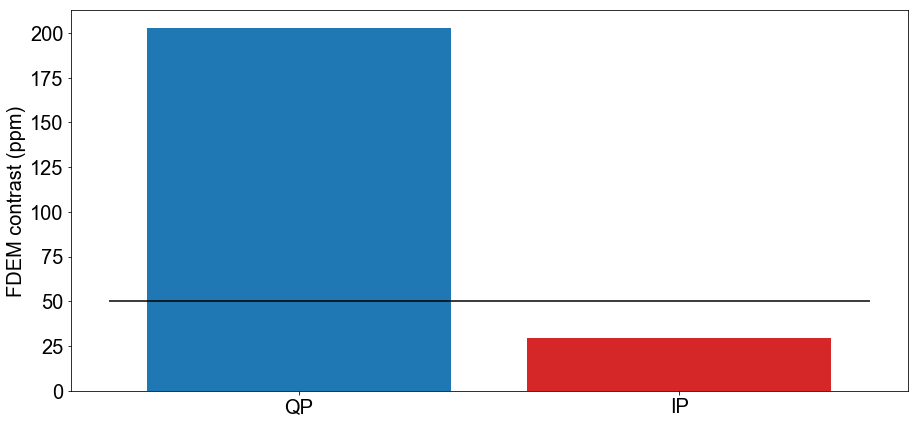

Contrast is detectable in the QP response: True
Contrast is detectable in the IP response: False


In [10]:
# Determine detectibility
contrast_in_qp = np.abs(qp_p2 - qp_p1)
contrast_in_ip = np.abs(ip_p2 - ip_p1)

# Visualize contrasts
plt.figure(figsize=(15, 7))
plt.hlines(noise, .5, 2.5)
plt.bar(1, contrast_in_qp, color='tab:blue')
plt.bar(2, contrast_in_ip, color='tab:red')
plt.xticks([1, 2], ['QP', 'IP'])
plt.ylabel('FDEM contrast (ppm)')
plt.show()

# Print results
print('Contrast is detectable in the QP response: ' + str((contrast_in_qp > noise)[0]))
print('Contrast is detectable in the IP response: ' + str((contrast_in_ip > noise)[0]))